# Abdelrahman Ayman Samy Mohamed, 222100930
# Yassmin Mohamed Mahmoud Metwally, 222101910
# Shahd Mamdouh Ali Hassan, 222102250
# Seif Amr Abdelhafez abdo , 222102312

In [4]:
import pandas as pd
import os

# Load ratings (MovieLens 20M)
ratings = pd.read_csv("../data/ratings.csv", usecols=["userId","movieId","rating"])

# Targets (headroom so it reliably meets constraints)
TARGET_USERS = 11000      # must end up > 10,000
TARGET_ITEMS = 600        # must end up >= 500
MIN_INTERACTIONS = 100000 # must end up >= 100,000

# Pick most active users
top_users = ratings["userId"].value_counts().head(TARGET_USERS).index
r_u = ratings[ratings["userId"].isin(top_users)].copy()

# Pick most popular items among those users
top_items = r_u["movieId"].value_counts().head(TARGET_ITEMS).index
subset = r_u[r_u["movieId"].isin(top_items)].copy()

# Verify constraints
print("Users:", subset["userId"].nunique())
print("Items:", subset["movieId"].nunique())
print("Interactions:", len(subset))

assert subset["userId"].nunique() > 10_000
assert subset["movieId"].nunique() >= 500
assert len(subset) >= MIN_INTERACTIONS

# Save
subset.to_csv("../data/ratings_subset.csv", index=False)


Users: 11000
Items: 600
Interactions: 3122081


In [5]:
ratings_subset=pd.read_csv("../data/ratings_subset.csv")

In [6]:
ratings_subset.head()

,userId,movieId,rating
0,11,1,4.5
1,11,10,2.5
2,11,19,3.5
3,11,32,5.0
4,11,39,4.5


In [7]:
ratings_subset.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [8]:
ratings_subset.shape

(3122081, 3)

# 3- Number Of Ratings per user

In [9]:
nu = ratings_subset.groupby('userId')['rating'].count().reset_index(name='Number Of Ratings per user')
nu.head()


,userId,Number Of Ratings per user
0,11,195
1,24,261
2,54,314
3,58,361
4,91,401


# 4- Number Of Ratings per movie

In [10]:
ni = ratings_subset.groupby('movieId')['rating'].count().reset_index(name='Number of Ratings per movie')
ni.head()


,movieId,Number of Ratings per movie
0,1,8987
1,2,6247
2,6,5644
3,10,6026
4,11,4209


# 5- Average Rating per Use

In [11]:
# Average rating per user
Fu = ratings_subset.groupby('userId')['rating'].mean().round(2).reset_index(name='Average Rating per User')
Fu.head()


,userId,Average Rating per User
0,11,4.34
1,24,3.64
2,54,3.77
3,58,4.20
4,91,3.43


# 6- Average Rating per movie

In [12]:
# Average rating per item
ri = ratings_subset.groupby('movieId')['rating'].mean().round(2).reset_index(name='Average Rating per Movie')
ri.head()


,movieId,Average Rating per Movie
0,1,3.85
1,2,2.96
2,6,3.80
3,10,3.30
4,11,3.46


# 7- Total number of ratings per item in ascendingly order 

In [13]:
ni_sorted = (
    ratings_subset.groupby('movieId')['rating']          
    .count()
    .reset_index(name='Number of Ratings per Movie')
    .sort_values('Number of Ratings per Movie', ascending=True)  
)

ni_sorted.head(10), ni_sorted.tail(10)


(     movieId  Number of Ratings per Movie
 483     4344                         3267
 381     2761                         3281
 109      745                         3282
 494     4734                         3283
 350     2478                         3286
 395     2948                         3288
 558     7458                         3291
 264     1717                         3294
 315     2109                         3294
 55       350                         3296,
      movieId  Number of Ratings per Movie
 161     1198                         9477
 159     1196                         9512
 40       260                         9587
 244     1580                         9599
 97       593                         9669
 45       296                         9746
 196     1270                         9768
 77       480                         9785
 57       356                         9922
 357     2571                         9960)

# Plot

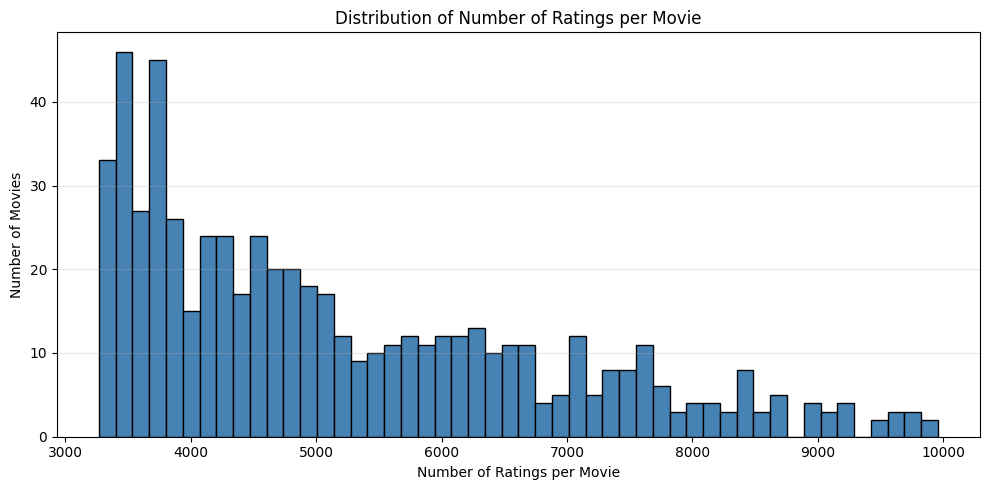

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(
    ni_sorted['Number of Ratings per Movie'],  # updated column name
    bins=50,
    color='steelblue',
    edgecolor='k'
)  # standard histogram usage [web:41][web:49]

plt.xlabel('Number of Ratings per Movie')
plt.ylabel('Number of Movies')
plt.title('Distribution of Number of Ratings per Movie')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
os.makedirs('../results/plots', exist_ok=True)
plt.savefig('../results/plots/distribution_of_number_of_ratings_per_movie.png', dpi=300, bbox_inches='tight')
plt.show()


# 8- Number of products based on their average ratings

In [15]:
# Number of ratings per item (movie)
ni = ratings_subset.groupby('movieId')['rating'].count().reset_index(name='NumRatings')  

# Sort items by number of ratings (descending: most popular first)
ni = ni.sort_values('NumRatings', ascending=False).reset_index(drop=True)   

total_ratings = ni['NumRatings'].sum()

# Cumulative share of ratings in %
ni['CumShare_pct'] = ni['NumRatings'].cumsum() / total_ratings * 100  

bins = [0, 1, 5, 10, 20, 30, 40, 50, 60, 70, 100]
labels = [f'G{i}' for i in range(1, 11)]

ni['Group'] = pd.cut(
    ni['CumShare_pct'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)  

group_counts = ni['Group'].value_counts(sort=False).reset_index()
group_counts.columns = ['Group', 'Count']
group_counts


,Group,Count
0,G1,3
1,G2,13
2,G3,18
3,G4,40
4,G5,44
5,G6,49
6,G7,55
7,G8,61
8,G9,68
9,G10,249


# 9- Total number of ratings in each group ascendingly

In [16]:
group_totals = (
    ni.groupby('Group', observed=True)['NumRatings']
      .sum()
      .reset_index(name='Total Ratings')
      .sort_values('Total Ratings', ascending=True)
)

group_totals

,Group,Total Ratings
0,G1,29667
1,G2,122421
2,G3,156040
4,G5,309851
7,G8,310816
5,G6,311403
3,G4,313545
8,G9,314771
6,G7,316431
9,G10,937136


# 10- Plot for number of ratings in each group before and after order 

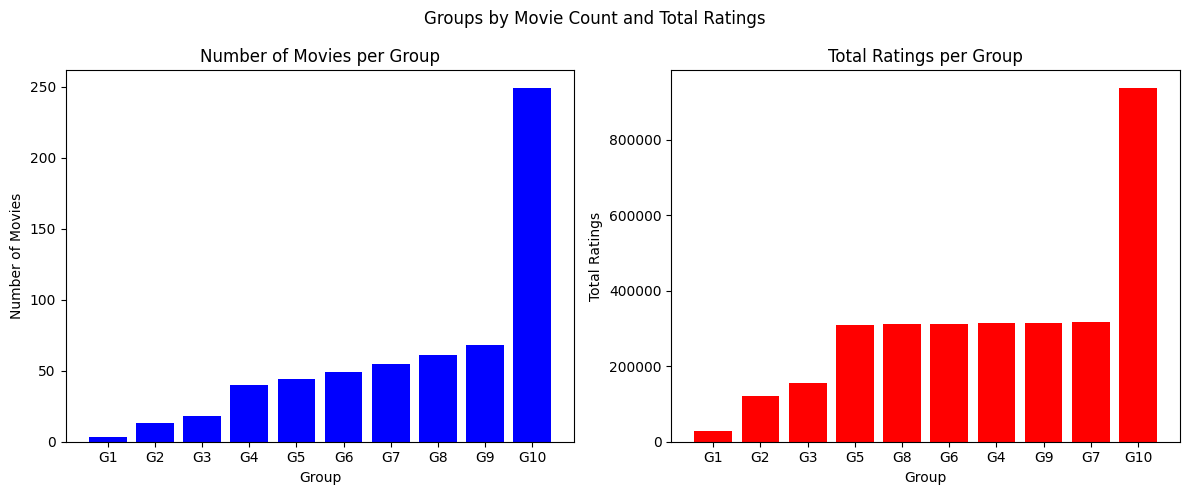

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Left: number of movies per group
counts_by_group = group_counts.set_index('Group')['Count'].reindex(labels).fillna(0)
axes[0].bar(counts_by_group.index, counts_by_group.values, color='blue')
axes[0].set_title('Number of Movies per Group')
axes[0].set_xlabel('Group')
axes[0].set_ylabel('Number of Movies')

# Right: total ratings per group
ordered = group_totals.sort_values('Total Ratings', ascending=True)
axes[1].bar(ordered['Group'], ordered['Total Ratings'], color='red')
axes[1].set_title('Total Ratings per Group')
axes[1].set_xlabel('Group')
axes[1].set_ylabel('Total Ratings')

plt.suptitle('Groups by Movie Count and Total Ratings')
plt.tight_layout()
os.makedirs('../results/plots', exist_ok=True)
plt.savefig('../results/plots/groups_by_movie_count_and_total_ratings.png', dpi=300, bbox_inches='tight')
plt.show()


# 11- Three target users

In [18]:
# total rows = total ratings
total_ratings = len(ratings_subset)

# build per-user counts with a consistent column name
nu = (
    ratings_subset.groupby('userId')['rating']
           .count()
           .reset_index(name='NumRatingsUser')
)

nu_pct = nu.copy()
nu_pct['Rating_pct_user'] = nu_pct['NumRatingsUser'] / total_ratings * 100

def pick_user(df, lower=None, upper=None, exclude_ids=None):
    if exclude_ids is None:
        exclude_ids = []
    mask = ~df['userId'].isin(exclude_ids)
    if lower is None and upper is not None:
        mask &= df['Rating_pct_user'] <= upper
    elif lower is not None and upper is None:
        mask &= df['Rating_pct_user'] > lower
    elif lower is not None and upper is not None:
        mask &= (df['Rating_pct_user'] > lower) & (df['Rating_pct_user'] <= upper)
    candidates = df[mask]
    if not candidates.empty:
        return candidates.sort_values('Rating_pct_user', ascending=False).iloc[0]
    low = 0 if lower is None else lower
    mid = low if upper is None else low + (upper - low) / 2
    remaining = df[~df['userId'].isin(exclude_ids)]
    return remaining.loc[(remaining['Rating_pct_user'] - mid).abs().idxmin()]

U1 = pick_user(nu_pct, lower=None, upper=2)
U2 = pick_user(nu_pct, lower=2, upper=5,  exclude_ids=[U1['userId']])
U3 = pick_user(nu_pct, lower=5, upper=10, exclude_ids=[U1['userId'], U2['userId']])

U1, U2, U3


(userId             8405.000000
 NumRatingsUser      600.000000
 Rating_pct_user       0.019218
 Name: 706, dtype: float64,
 userId             118205.000000
 NumRatingsUser        598.000000
 Rating_pct_user         0.019154
 Name: 9382, dtype: float64,
 userId             88604.00000
 NumRatingsUser       596.00000
 Rating_pct_user        0.01909
 Name: 7020, dtype: float64)

# 12- Two target items

In [19]:
ri_with_counts = ri.merge(
    ni[['movieId', 'NumRatings']],
    on='movieId',
    how='left'
)

min_ratings = 5
ri_filtered = ri_with_counts[ri_with_counts['NumRatings'] >= min_ratings].copy()
print("Number of items with at least", min_ratings, "ratings:", len(ri_filtered))

ri_sorted = ri_filtered.sort_values(
    by=['Average Rating per Movie', 'NumRatings'],      
    ascending=[True, True]
)

I1 = ri_sorted.iloc[0]
I2 = ri_sorted.iloc[1]

print("I1 (lowest rated item):")
print(I1)
print("\nI2 (second lowest rated item):")
print(I2)


Number of items with at least 5 ratings: 600
I1 (lowest rated item):
movieId                     1562.00
Average Rating per Movie       2.06
NumRatings                  4643.00
Name: 241, dtype: float64

I2 (second lowest rated item):
movieId                     2701.00
Average Rating per Movie       2.18
NumRatings                  4701.00
Name: 373, dtype: float64


# 13- Saving

In [20]:
results_path = r"..\results\tables"
os.makedirs(results_path, exist_ok=True)

# Task 3: Ratings per user
nu.to_csv(fr"{results_path}\Number_Of_Ratings_per_user.csv", index=False)

# Task 4: Ratings per movie
ni.to_csv(fr"{results_path}\Number_Of_Ratings_per_movie.csv", index=False)

# Task 5: Average rating per user
Fu.to_csv(fr"{results_path}\Average_Rating_per_User.csv", index=False)

# Task 6: Average rating per item/movie
ri.to_csv(fr"{results_path}\Average_Rating_per_Movie.csv", index=False)

# Task 7: Items sorted by number of ratings
ni_sorted.to_csv(fr"{results_path}\Items_Sorted_by_NumRatings.csv", index=False)

# Tasks 8–10: Group assignments and group summaries
ni.to_csv(fr"{results_path}\Items_with_Groups_by_CumShare.csv", index=False)
group_counts.to_csv(fr"{results_path}\Item_Count_per_Group.csv", index=False)
group_totals.to_csv(fr"{results_path}\Total_Ratings_Per_Group.csv", index=False)

# Task 11: Target users
pd.DataFrame([U1, U2, U3]).to_csv(fr"{results_path}\Target_Users_U1_U2_U3.csv", index=False)

# Task 12: Target items
pd.DataFrame([I1, I2]).to_csv(fr"{results_path}\Target_Items_I1_I2.csv", index=False)


# 1- USER GROUPS Cold

In [21]:
import pandas as pd

total_ratings = len(ratings_subset)

nu = (ratings_subset.groupby("userId")["rating"]
      .count()
      .reset_index(name="NumRatingsUser"))

nu["UserRatingPct"] = (nu["NumRatingsUser"] / total_ratings) * 100

cold_users = nu.loc[nu["UserRatingPct"] < 2, "userId"].tolist()
cold_users[:10], len(cold_users)


([11, 24, 54, 58, 91, 96, 104, 116, 131, 134], 11000)

# 2- USER GROUPS Medium

In [22]:
total_ratings = len(ratings_subset)

nu = (ratings_subset.groupby("userId")["rating"]
      .count()
      .reset_index(name="NumRatingsUser"))

nu["UserRatingPct"] = (nu["NumRatingsUser"] / total_ratings) * 100

medium_users = nu.loc[
    (nu["UserRatingPct"] >= 2) & (nu["UserRatingPct"] <= 5),
    "userId"
].tolist()
medium_users[:10], len(medium_users)


([], 0)

# 3- USER GROUPS Rich

In [23]:
total_ratings = len(ratings_subset)

nu = (ratings_subset.groupby("userId")["rating"]
      .count()
      .reset_index(name="NumRatingsUser"))

nu["UserRatingPct"] = (nu["NumRatingsUser"] / total_ratings) * 100

rich_users = nu.loc[nu["UserRatingPct"] > 10, "userId"].tolist()
rich_users[:10], len(rich_users)


([], 0)

# 4- ITEM POPULARITY (Low/Medium/High)

In [24]:
item_stats = (
    ratings_subset.groupby("movieId")["rating"]
    .count()
    .reset_index(name="NumRatingsItem")
)

# Percentile cutoffs
q1 = item_stats["NumRatingsItem"].quantile(1/3)
q2 = item_stats["NumRatingsItem"].quantile(2/3)

def popularity_bin(x, q1, q2):
    if x <= q1:
        return "low"
    elif x <= q2:
        return "medium"
    else:
        return "high"

item_stats["PopularityGroup"] = item_stats["NumRatingsItem"].apply(lambda x: popularity_bin(x, q1, q2))

low_pop_items    = item_stats.loc[item_stats["PopularityGroup"] == "low", "movieId"].tolist()
medium_pop_items = item_stats.loc[item_stats["PopularityGroup"] == "medium", "movieId"].tolist()
high_pop_items   = item_stats.loc[item_stats["PopularityGroup"] == "high", "movieId"].tolist()

item_stats["PopularityGroup"].value_counts()


PopularityGroup
high      200
medium    200
low       200
Name: count, dtype: int64

# 5- SAVE ALL PREPROCESSING OUTPUTS

In [25]:
results_path = r"..\results\tables"
os.makedirs(results_path, exist_ok=True)

# Create user_stats with group assignments
user_stats = nu.copy()
user_stats['UserGroup'] = pd.cut(
	user_stats['UserRatingPct'],
	bins=[0, 2, 5, 10, 100],
	labels=['cold', 'medium', 'rich', 'super_rich'],
	include_lowest=True
)

# Create user_group_counts
user_group_counts = user_stats['UserGroup'].value_counts().reset_index()
user_group_counts.columns = ['UserGroup', 'Count']

# Save tables (CSV)
user_stats.to_csv(os.path.join(results_path, "user_stats_with_groups.csv"), index=False)
item_stats.to_csv(os.path.join(results_path, "item_stats_with_popularity.csv"), index=False)
user_group_counts.to_csv(os.path.join(results_path, "user_group_counts.csv"), index=False)

# Save ID lists as CSV (easy to reload)
pd.Series(cold_users, name="userId").to_csv(os.path.join(results_path, "cold_users.csv"), index=False)
pd.Series(medium_users, name="userId").to_csv(os.path.join(results_path, "medium_users.csv"), index=False)
pd.Series(rich_users, name="userId").to_csv(os.path.join(results_path, "rich_users.csv"), index=False)

pd.Series(low_pop_items, name="movieId").to_csv(os.path.join(results_path, "low_pop_items.csv"), index=False)
pd.Series(medium_pop_items, name="movieId").to_csv(os.path.join(results_path, "medium_pop_items.csv"), index=False)
pd.Series(high_pop_items, name="movieId").to_csv(os.path.join(results_path, "high_pop_items.csv"), index=False)


# 1-Average rating for each of the target items (I1 and I2)

In [26]:
ti = pd.read_csv("../results/tables/Target_Items_I1_I2.csv")                  
target_items = ti["movieId"].astype("int64").tolist()

print("Target items:", target_items)
avg_target_items = (ratings_subset[ratings_subset["movieId"].isin(target_items)]
                    .groupby("movieId")["rating"]
                    .mean()
                    .round(2)
                    .reset_index(name="avg_rating"))

print(avg_target_items)
avg_target_items.to_csv("../results/tables/task1_avg_target_items.csv", index=False)


Target items: [1562, 2701]
   movieId  avg_rating
0     1562        2.06
1     2701        2.18


# 2-Use the mean-filling method to replace the unspecified ratings of each of the target items (I1 and I2) with its corresponding mean value

In [27]:
R_I = ratings_subset[ratings_subset["movieId"].isin(target_items)].pivot_table(
    index="userId", columns="movieId", values="rating", aggfunc="mean"
)

item_means_I = R_I.mean(axis=0)
R_I_filled = R_I.fillna(item_means_I).round(2)

print("R_I shape:", R_I.shape)
print("Missing after fill:", R_I_filled.isna().sum().sum())

R_I_filled.to_csv("../results/tables/task2_R_I1_I2_mean_filled.csv")


R_I shape: (6542, 2)
Missing after fill: 0


# 3- Average rating for each item (all items)

In [28]:
item_means_all = (ratings_subset.groupby("movieId")["rating"]
                  .mean()
                  .round(2)
                  .reset_index(name="avg_rating"))

print(item_means_all.head(10))
item_means_all.to_csv("../results/tables/task3_item_means_all.csv", index=False)


   movieId  avg_rating
0        1        3.85
1        2        2.96
2        6        3.80
3       10        3.30
4       11        3.46
5       16        3.79
6       17        3.78
7       19        2.47
8       21        3.48
9       25        3.64


# 4- Differences (rating − item mean) for each item

In [29]:
R = ratings_subset.pivot_table(index="userId", columns="movieId", values="rating", aggfunc="mean")

item_means = R.mean(axis=0)
R_filled = R.fillna(item_means)          # mean-fill per item
D = R_filled - R_filled.mean(axis=0)     # centered (differences)

print("R shape:", R.shape)
print("D shape:", D.shape)
print("Missing in D:", D.isna().sum().sum())
print(D.iloc[:5, :5].round(2))


R shape: (11000, 600)
D shape: (11000, 600)
Missing in D: 0
movieId    1     2    6    10    11
userId                             
11       0.65 -0.00 -0.0 -0.8 -0.00
24       0.15 -0.00  0.2 -0.3 -0.00
54       0.15  0.04 -0.8  0.7  1.54
58       1.15 -0.00  0.7  0.0  1.04
91       0.15  0.54 -0.0  0.7  0.54


# 5- Covariance for each two items

In [30]:
import numpy as np
i, j = R_filled.columns[0], R_filled.columns[1]

cov_ij = np.cov(D[i].to_numpy(), D[j].to_numpy(), bias=False)[0, 1]
print("Example items:", i, j)
print("Cov(i,j) =", cov_ij)


Example items: 1 2
Cov(i,j) = 0.12168481621033125


# 6- Generate full covariance matrix (items × items)

In [31]:
C = np.cov(D.to_numpy(dtype=np.float64), rowvar=False, bias=False)
cov_df = pd.DataFrame(C, index=R_filled.columns, columns=R_filled.columns)

print("Covariance matrix shape:", cov_df.shape)

# Save (CSV + NPY)
cov_df.to_csv("../results/tables/task6_covariance_matrix.csv")
np.save("../results/tables/task6_covariance_matrix.npy", C)


Covariance matrix shape: (600, 600)


# 7- Top-5 peers and Top-10 peers for I1 and I2 (using covariance)

In [32]:
cov_df = pd.read_csv("../results/tables/task6_covariance_matrix.csv", index_col=0)
cov_df.columns = cov_df.columns.astype(int)  # ensure movieId int columns
cov_df.index = cov_df.index.astype(int)

rows = []
for t in target_items:
    sims = cov_df.loc[t].drop(index=t).sort_values(ascending=False)
    top5 = sims.head(5)
    top10 = sims.head(10)

    for r, (mid, val) in enumerate(top5.items(), start=1):
        rows.append({"target_item": t, "peer_type": "top5", "rank": r,
                     "peer_movieId": int(mid), "covariance": float(val)})
    for r, (mid, val) in enumerate(top10.items(), start=1):
        rows.append({"target_item": t, "peer_type": "top10", "rank": r,
                     "peer_movieId": int(mid), "covariance": float(val)})

peers_df = pd.DataFrame(rows)
print(peers_df.head(15))
peers_df.to_csv("../results/tables/task7_peers_top5_top10.csv", index=False)


    target_item peer_type  rank  peer_movieId  covariance
0          1562      top5     1           153    0.220736
1          1562      top5     2          2628    0.157105
2          1562      top5     3          1917    0.156351
3          1562      top5     4           780    0.152011
4          1562      top5     5           736    0.125528
5          1562     top10     1           153    0.220736
6          1562     top10     2          2628    0.157105
7          1562     top10     3          1917    0.156351
8          1562     top10     4           780    0.152011
9          1562     top10     5           736    0.125528
10         1562     top10     6          2701    0.118815
11         1562     top10     7          1544    0.116595
12         1562     top10     8          1552    0.114016
13         1562     top10     9          3623    0.108686
14         1562     top10    10          2617    0.107273


# 8- Reduced space for each user (top-5 peers)

In [33]:
peers_df = pd.read_csv("../results/tables/task7_peers_top5_top10.csv")

for t in target_items:
    top5_items = peers_df[(peers_df["target_item"]==t) & (peers_df["peer_type"]=="top5")]["peer_movieId"].tolist()
    X5 = R_filled[top5_items]  # users × 5

    print("Target:", t, "| reduced space top5 shape:", X5.shape)
    X5.to_csv(f"../results/tables/task8_reduced_space_top5_target{t}.csv")


Target: 1562 | reduced space top5 shape: (11000, 5)
Target: 2701 | reduced space top5 shape: (11000, 5)


# 9- Predict missing ratings for I1/I2 using top-5 peers

In [34]:
cov_df = pd.read_csv("../results/tables/task6_covariance_matrix.csv", index_col=0)
cov_df.columns = cov_df.columns.astype(int)
cov_df.index = cov_df.index.astype(int)

peers_df = pd.read_csv("../results/tables/task7_peers_top5_top10.csv")

def predict_with_cov(R_filled, cov_df, target_item, peer_items):
    w = cov_df.loc[target_item, peer_items].to_numpy(dtype=np.float64)
    denom = np.sum(np.abs(w)) + 1e-12
    return (R_filled[peer_items].to_numpy(dtype=np.float64) @ w) / denom

pred_rows = []
for t in target_items:
    top5_items = peers_df[(peers_df["target_item"]==t) & (peers_df["peer_type"]=="top5")]["peer_movieId"].tolist()

    preds = predict_with_cov(R_filled, cov_df, t, top5_items)
    was_missing = R[t].isna().to_numpy()  # only originally missing in raw R

    tmp = pd.DataFrame({
        "userId": R.index.to_numpy(),
        "target_item": t,
        "pred_top5": preds,
        "was_missing": was_missing
    })
    pred_rows.append(tmp)

pred_top5 = pd.concat(pred_rows, ignore_index=True)
pred_top5 = pred_top5[pred_top5["was_missing"]].copy()
pred_top5["pred_top5"] = pred_top5["pred_top5"].round(2)

print(pred_top5.head(10))
pred_top5.to_csv("../results/tables/task9_predictions_top5_missing.csv", index=False)


    userId  target_item  pred_top5  was_missing
0       11         1562       4.50         True
1       24         1562       3.21         True
3       58         1562       2.64         True
4       91         1562       2.90         True
5       96         1562       2.84         True
6      104         1562       2.84         True
8      131         1562       2.94         True
9      134         1562       2.87         True
10     156         1562       3.72         True
12     220         1562       2.48         True


# 10- Reduced space for each user (top-10 peers)

In [35]:
peers_df = pd.read_csv("../results/tables/task7_peers_top5_top10.csv")

for t in target_items:
    top10_items = peers_df[(peers_df["target_item"]==t) & (peers_df["peer_type"]=="top10")]["peer_movieId"].tolist()
    X10 = R_filled[top10_items]  # users × 10

    print("Target:", t, "| reduced space top10 shape:", X10.shape)
    X10.to_csv(f"../results/tables/task10_reduced_space_top10_target{t}.csv")


Target: 1562 | reduced space top10 shape: (11000, 10)
Target: 2701 | reduced space top10 shape: (11000, 10)


# 11- Predict missing ratings for I1/I2 using top-10 peers

In [36]:
cov_df = pd.read_csv("../results/tables/task6_covariance_matrix.csv", index_col=0)
cov_df.columns = cov_df.columns.astype(int)
cov_df.index = cov_df.index.astype(int)

peers_df = pd.read_csv("../results/tables/task7_peers_top5_top10.csv")

pred_rows = []
for t in target_items:
    top10_items = peers_df[(peers_df["target_item"]==t) & (peers_df["peer_type"]=="top10")]["peer_movieId"].tolist()

    preds = predict_with_cov(R_filled, cov_df, t, top10_items)
    was_missing = R[t].isna().to_numpy()

    tmp = pd.DataFrame({
        "userId": R.index.to_numpy(),
        "target_item": t,
        "pred_top10": preds,
        "was_missing": was_missing
    })
    pred_rows.append(tmp)

pred_top10 = pd.concat(pred_rows, ignore_index=True)
pred_top10 = pred_top10[pred_top10["was_missing"]].copy()
pred_top10["pred_top10"] = pred_top10["pred_top10"].round(2)

print(pred_top10.head(10))
pred_top10.to_csv("../results/tables/task11_predictions_top10_missing.csv", index=False)


    userId  target_item  pred_top10  was_missing
0       11         1562        3.98         True
1       24         1562        3.04         True
3       58         1562        2.85         True
4       91         1562        2.74         True
5       96         1562        2.82         True
6      104         1562        2.63         True
8      131         1562        2.78         True
9      134         1562        2.82         True
10     156         1562        3.73         True
12     220         1562        2.66         True


# 12- Compare results of top-5 vs top-10 (and comment)

In [37]:
top5 = pd.read_csv("../results/tables/task9_predictions_top5_missing.csv")
top10 = pd.read_csv("../results/tables/task11_predictions_top10_missing.csv")

cmp = top5.merge(top10, on=["userId","target_item","was_missing"], how="inner")

# Summary per target item
summary = cmp.groupby("target_item")[["pred_top5","pred_top10"]].agg(["mean","std"]).round(3)
print(summary)

summary.to_csv("../results/tables/task12_compare_top5_vs_top10_summary.csv")
cmp.to_csv("../results/tables/task12_top5_vs_top10_all_users_missing.csv", index=False)


            pred_top5        pred_top10       
                 mean    std       mean    std
target_item                                   
1562            2.825  0.489      2.811  0.394
2701            3.040  0.540      2.849  0.421


In [ ]:
A = R_filled.to_numpy(dtype=np.float64)

# PCA via SVD on centered data
X = A - A.mean(axis=0, keepdims=True)
U, s, VT = np.linalg.svd(X, full_matrices=False)

k_values = [5, 20, 50, 100]   # use same k list as your SVD section
rows = []
for k in k_values:
    X_hat = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
    A_hat = X_hat + A.mean(axis=0, keepdims=True)
    rows.append({
        "k": k,
        "MAE": float(np.mean(np.abs(A - A_hat))),
        "RMSE": float(np.sqrt(np.mean((A - A_hat)**2)))
    })

pca_err = pd.DataFrame(rows)
pca_err.to_csv("../results/tables/pca_meanfill_reconstruction_errors.csv", index=False)


In [ ]:
tu = pd.read_csv("../results/tables/Target_Users_U1_U2_U3.csv")
ti = pd.read_csv("../results/tables/Target_Items_I1_I2.csv")

target_users = tu["userId"].tolist()
target_items = ti["movieId"].tolist()

# You need a PCA mean-fill predictor matrix A_hat for your chosen k (e.g., k=20).
k = 20
X_hat = U[:, :k] @ np.diag(s[:k]) @ VT[:k, :]
A_hat = X_hat + A.mean(axis=0, keepdims=True)

# R must be your original pivot (with NaNs) so we can get true ratings only where available
pairs = []
user_index = list(R.index)
item_index = list(R.columns)

for u in target_users:
    for m in target_items:
        if (u in R.index) and (m in R.columns):
            true = R.loc[u, m]
            if pd.notna(true):
                pred = A_hat[user_index.index(u), item_index.index(m)]
                pairs.append({"userId": u, "movieId": m, "true_rating": float(true), "pred_rating": float(pred)})

pca_pairs = pd.DataFrame(pairs)
pca_pairs.to_csv("../results/tables/pca_meanfill_eval_pairs.csv", index=False)


In [ ]:
import time

A = R_filled.to_numpy(dtype=np.float64)
X = A - A.mean(axis=0, keepdims=True)
k = 20

t0 = time.perf_counter()
U, s, VT = np.linalg.svd(X, full_matrices=False)
t_decomp = time.perf_counter() - t0

Uk = U[:, :k]
sk = s[:k]
VTk = VT[:k, :]

mem_mb = (Uk.nbytes + sk.nbytes + VTk.nbytes) / (1024**2)

t1 = time.perf_counter()
X_hat = Uk @ np.diag(sk) @ VTk
A_hat = X_hat + A.mean(axis=0, keepdims=True)
t_pred = time.perf_counter() - t1

pca_perf = pd.DataFrame([{
    "method": "PCA mean-fill (k=20)",
    "time_decomposition_sec": round(t_decomp, 4),
    "time_prediction_sec": round(t_pred, 4),
    "memory_factors_MB": round(mem_mb, 2)
}])

print(pca_perf.to_string(index=False))
pca_perf.to_csv("../results/tables/pca_meanfill_runtime_memory.csv", index=False)


              method  time_decomposition_sec  time_prediction_sec  memory_factors_MB
PCA mean-fill (k=20)                   0.987               0.0541               1.77
